In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def apply_gamma_correction(img, gamma=2.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

In [3]:
def is_underexposed(img, threshold=70):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel = lab[:, :, 0]
    mean_luminance = np.mean(l_channel)
    return mean_luminance < threshold

In [4]:
def is_blurry(img, threshold=100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

In [5]:
def unsharp_mask(img):
    gaussian = cv2.GaussianBlur(img, (9, 9), 10.0)
    unsharp = cv2.addWeighted(img, 1.5, gaussian, -0.5, 0)
    return unsharp

In [6]:
def is_noisy(img, threshold=20):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    stddev = np.std(lap)
    return stddev > threshold

In [7]:
def denoise_image(img):
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 20, 7, 35)

In [8]:
def contrast_stretching(img):
    img_float = img.astype(np.float32)
    min_val = np.min(img_float)
    max_val = np.max(img_float)

    if max_val - min_val == 0:
        return img.copy()

    stretched = ((img_float - min_val) / (max_val - min_val)) * 255
    stretched = stretched.astype(np.uint8)
    
    return stretched

In [9]:
def apply_clahe_lab_exposure(image, clip_limit=2.0, tile_grid_size=(4, 4)):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    L_eq = clahe.apply(L)
    lab_eq = cv2.merge((L_eq, A, B))
    img_exposed = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)

    return img_exposed

In [10]:
def smart_preprocess(img):
    print("Starting Smart Preprocessing...")

    if is_underexposed(img):
        print("Image is underexposed. Applying gamma correction.")
        img = apply_gamma_correction(img, gamma=2.0)
    
    if is_blurry(img):
        print("Image is blurry. Applying unsharp masking.")
        img = unsharp_mask(img)
    
    if is_noisy(img):
        print("Image is noisy. Applying denoising.")
        img = denoise_image(img)
    
    return img

In [11]:
def display(img1,img2):
    plt.figure(figsize=(35,35))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title("Output Image")

In [12]:
img1 = cv2.imread(r"PATH/TO/IMAGE")

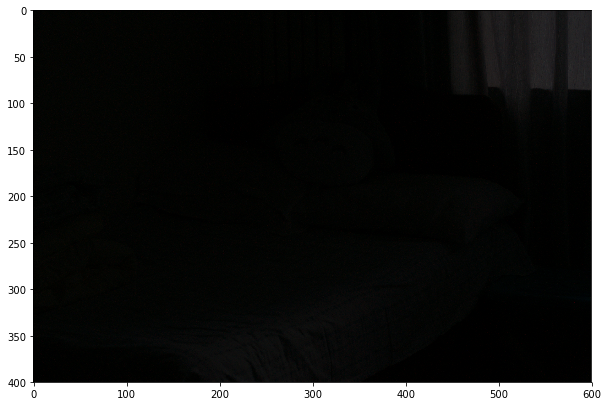

In [13]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img1)

In [14]:
def display_previews(title, images, labels):
    plt.figure(figsize=(20, 8))  
    for i, (img, label) in enumerate(zip(images, labels)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')

    plt.suptitle(title, y=0.90, fontsize=16)  
    plt.tight_layout(rect=[0, 0, 1, 0.88])  
    plt.show()


## Global Exposure

In [15]:
def stage_global_exposure(img):
    def adjust_gamma(image, gamma):
        look_up_table = np.array([
            ((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(image, look_up_table)

    preview_gammas = [0.5, 1.0, 1.5]
    previews = [adjust_gamma(img, g) for g in preview_gammas]
    display_previews(
        "Global Exposure - Previews",
        previews,
        [f"Gamma {g}" for g in preview_gammas]
    )

    def on_trackbar(val):
        gamma = val / 100
        if gamma <= 0:
            gamma = 0.01  
        adjusted = adjust_gamma(img, gamma)
        cv2.imshow("Adjust Gamma", adjusted)

    cv2.namedWindow("Adjust Gamma", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Adjust Gamma", 700, 800)
    cv2.createTrackbar("Gamma ", "Adjust Gamma", 100, 300, on_trackbar)
    on_trackbar(100)  

    print("Adjust the trackbar, press any key when satisfied...")
    cv2.waitKey(0)

    gamma_value = cv2.getTrackbarPos("Gamma ", "Adjust Gamma") / 100
    if gamma_value <= 0:
        gamma_value = 0.01

    cv2.destroyWindow("Adjust Gamma")
    return adjust_gamma(img, gamma_value)


## White Balance Correction

In [16]:
def stage_white_balance(img):
    def white_balance(image):
        result = image.copy().astype(np.float32)
        avg_b = np.mean(result[:, :, 0])
        avg_g = np.mean(result[:, :, 1])
        avg_r = np.mean(result[:, :, 2])
        avg_gray = (avg_b + avg_g + avg_r) / 3
        result[:, :, 0] *= avg_gray / avg_b
        result[:, :, 1] *= avg_gray / avg_g
        result[:, :, 2] *= avg_gray / avg_r
        return np.clip(result, 0, 255).astype(np.uint8)

    corrected = white_balance(img)
    display_previews("White Balance", [img, corrected], ["Original", "Corrected"])
    return corrected

## Local Tone Mapping

In [17]:
def stage_local_tone_mapping(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    l_filtered = cv2.bilateralFilter(l, d=7, sigmaColor=75, sigmaSpace=75)
    lab_filtered = cv2.merge((l_filtered, a, b))
    tone_mapped_img = cv2.cvtColor(lab_filtered, cv2.COLOR_LAB2BGR)
    display_previews("Local Tone Mapping", [img, tone_mapped_img], ["Original", "Tone Mapped"])
    return tone_mapped_img

## Colour Enhancement

In [18]:
def stage_colour_enhancement(img):
    def adjust_saturation(image, factor):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:, :, 1] = cv2.multiply(hsv[:, :, 1], factor)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    preview_factors = [0.8, 1.0, 1.2]
    previews = [adjust_saturation(img, f) for f in preview_factors]
    display_previews("Colour Enhancement - Previews", previews, [f"Saturation {f}" for f in preview_factors])

    def on_trackbar(val):
        factor = val / 100
        adjusted = adjust_saturation(img, factor)
        cv2.imshow("Adjust Saturation", adjusted)

    cv2.namedWindow("Adjust Saturation", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Adjust Saturation", 700, 800)
    cv2.createTrackbar("Saturation :", "Adjust Saturation", 100, 300, on_trackbar)
    on_trackbar(100)

    print("Adjust the trackbar, press any key when satisfied...")
    cv2.waitKey(0)
    sat_value = cv2.getTrackbarPos("Saturation :", "Adjust Saturation") / 100
    cv2.destroyWindow("Adjust Saturation")
    return adjust_saturation(img, sat_value)

## Sharpening

In [19]:
def stage_sharpening(img):
    def adjust_sharpness(image, alpha):
        blurred = cv2.GaussianBlur(image, (0, 0), 1.2)
        return cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)

    preview_alphas = [0.5, 1.0, 1.5]
    previews = [adjust_sharpness(img, a) for a in preview_alphas]
    display_previews("Sharpening - Previews", previews, [f"Alpha {a}" for a in preview_alphas])

    def on_trackbar(val):
        alpha = val / 100
        adjusted = adjust_sharpness(img, alpha)
        cv2.imshow("Adjust Sharpness", adjusted)

    cv2.namedWindow("Adjust Sharpness", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Adjust Sharpness", 700, 800)
    cv2.createTrackbar("Sharpness: ", "Adjust Sharpness", 100, 300, on_trackbar)
    on_trackbar(100)

    print("Adjust the trackbar, press any key when satisfied...")
    cv2.waitKey(0)
    sharp_value = cv2.getTrackbarPos("Sharpness :", "Adjust Sharpness") / 100
    cv2.destroyWindow("Adjust Sharpness")
    return adjust_sharpness(img, sharp_value)


## Pipeline Order

In [20]:
pipeline_stages = {
    "global_exposure": stage_global_exposure,
    "white_balance": stage_white_balance,
    "local_tone_mapping": stage_local_tone_mapping,
    "colour_enhancement": stage_colour_enhancement,
    "sharpening": stage_sharpening,
    "contrast_stretching": contrast_stretching,
    "noise_filtering": denoise_image,
    "contrast limited adaptive histogram equalization": apply_clahe_lab_exposure
}

#Pipeline for Coloured Images

pipeline_c_order = [
    "global_exposure",
    "white_balance",
    "local_tone_mapping",
    "colour_enhancement",
    "sharpening"
]

#Pipeline for Extremely Dull Images

pipeline_d_order = [
    "contrast_stretching",
    "noise_filtering",
    "global_exposure",
    "white_balance",
    "contrast limited adaptive histogram equalization",
    "colour_enhancement"
]

## Main Execution

Starting Smart Preprocessing...
Image is underexposed. Applying gamma correction.
Image is noisy. Applying denoising.
--- Stage: contrast_stretching ---
--- Stage: noise_filtering ---
--- Stage: global_exposure ---


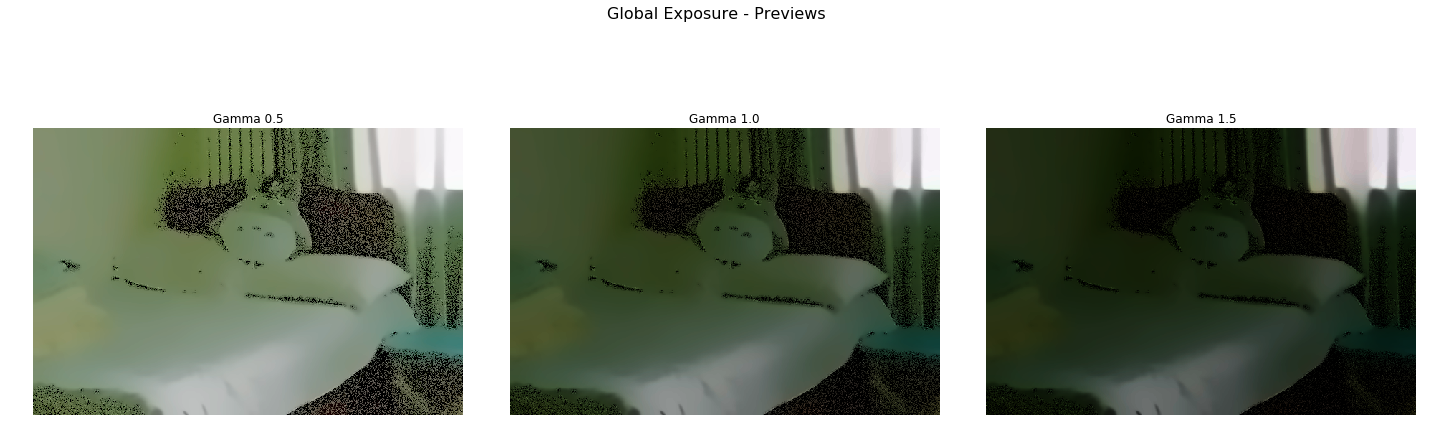

Adjust the trackbar, press any key when satisfied...
--- Stage: white_balance ---


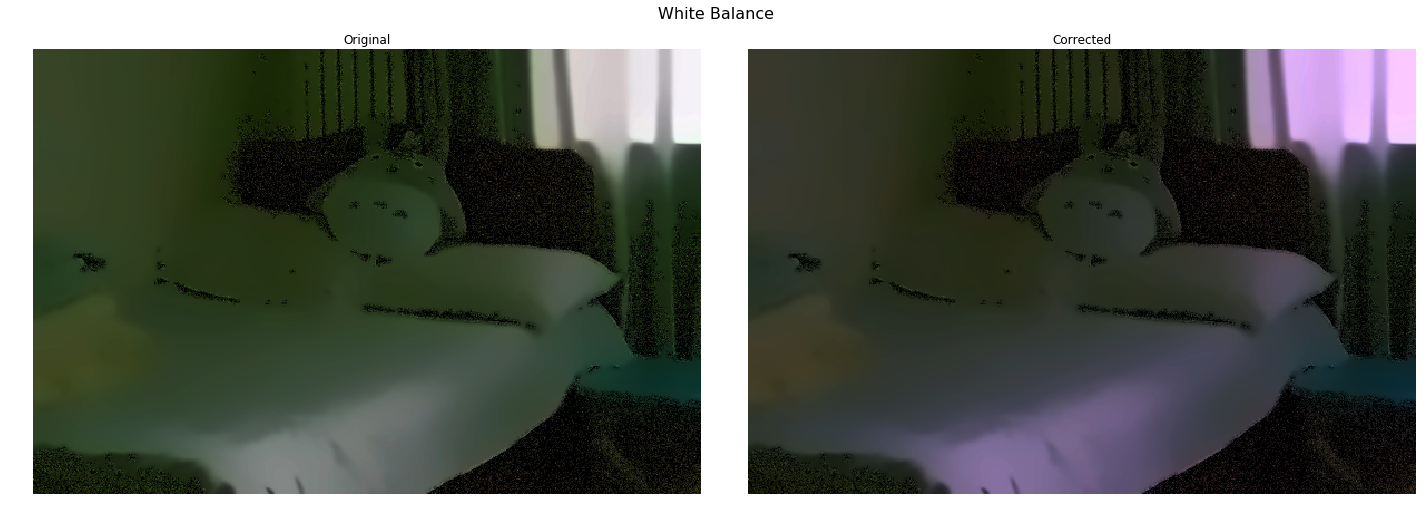

--- Stage: contrast limited adaptive histogram equalization ---
--- Stage: colour_enhancement ---


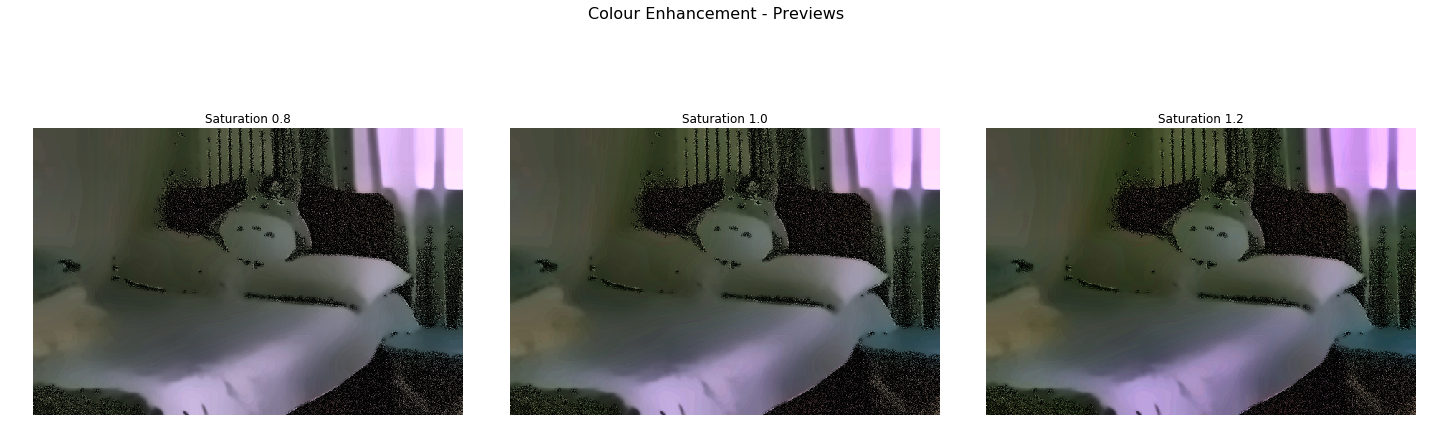

Adjust the trackbar, press any key when satisfied...


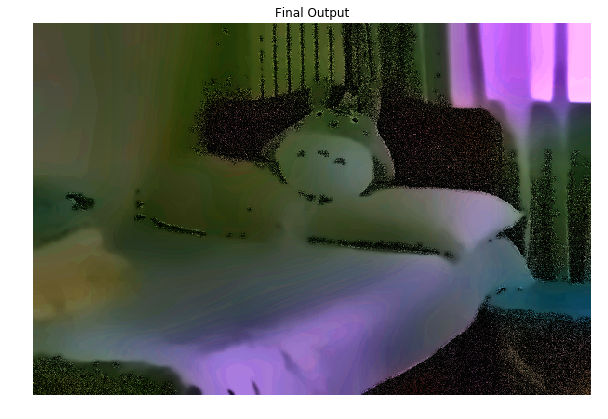

In [21]:
if __name__ == "__main__":
    img1 = cv2.imread(r"PATH/TO/IMAGE")
    img = smart_preprocess(img1)

    current_img = img
    for stage_name in pipeline_d_order:
        print(f"--- Stage: {stage_name} ---")
        current_img = pipeline_stages[stage_name](current_img)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))
    plt.title("Final Output")
    plt.axis('off')
    plt.show()

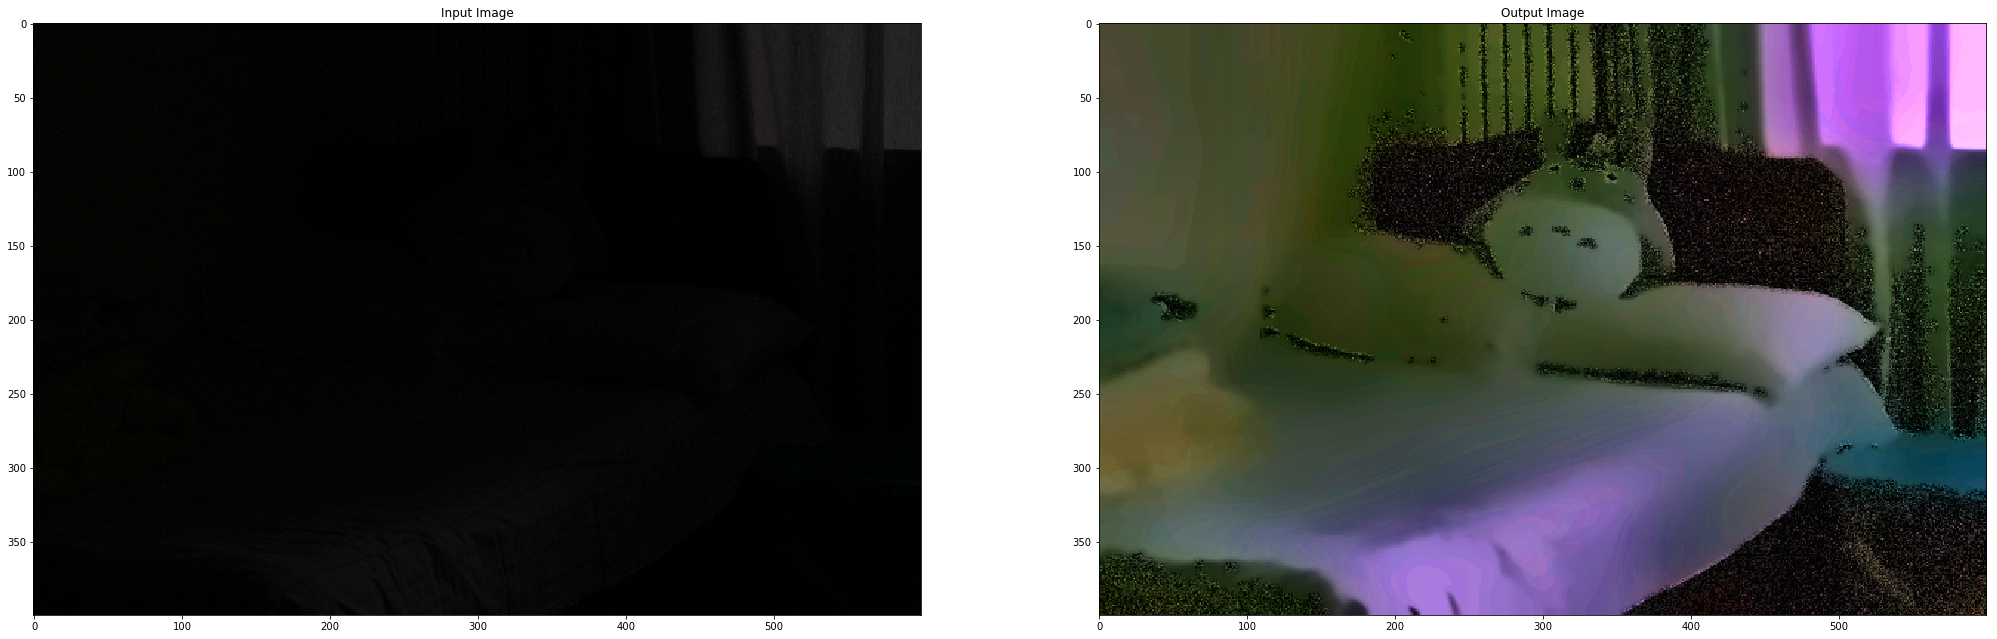

In [22]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
current_img = cv2.cvtColor(current_img,cv2.COLOR_BGR2RGB)
display(img1,current_img)

Starting Smart Preprocessing...
Image is noisy. Applying denoising.
--- Stage: global_exposure ---


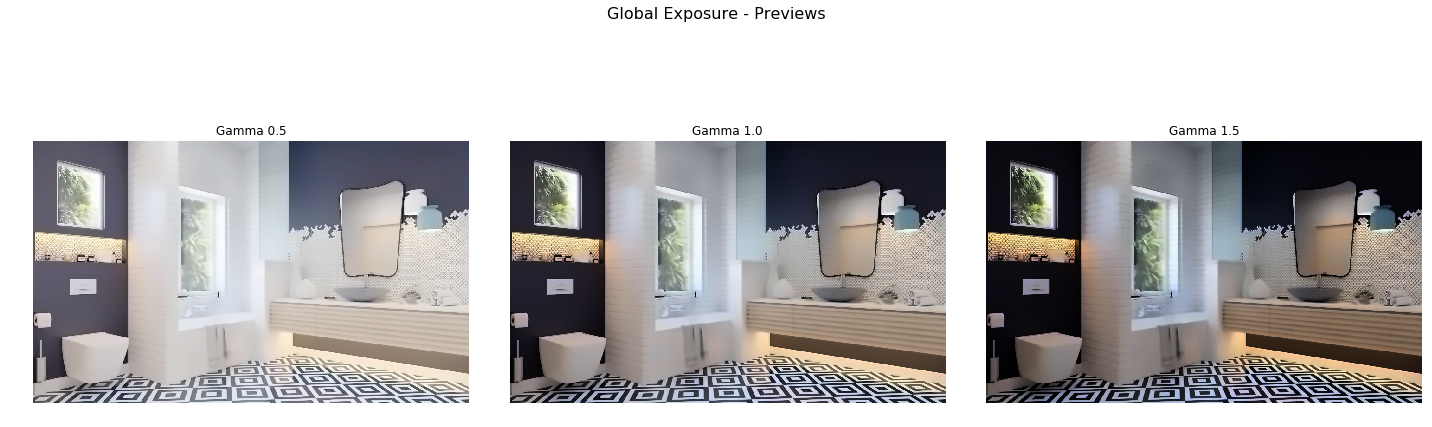

Adjust the trackbar, press any key when satisfied...
--- Stage: white_balance ---


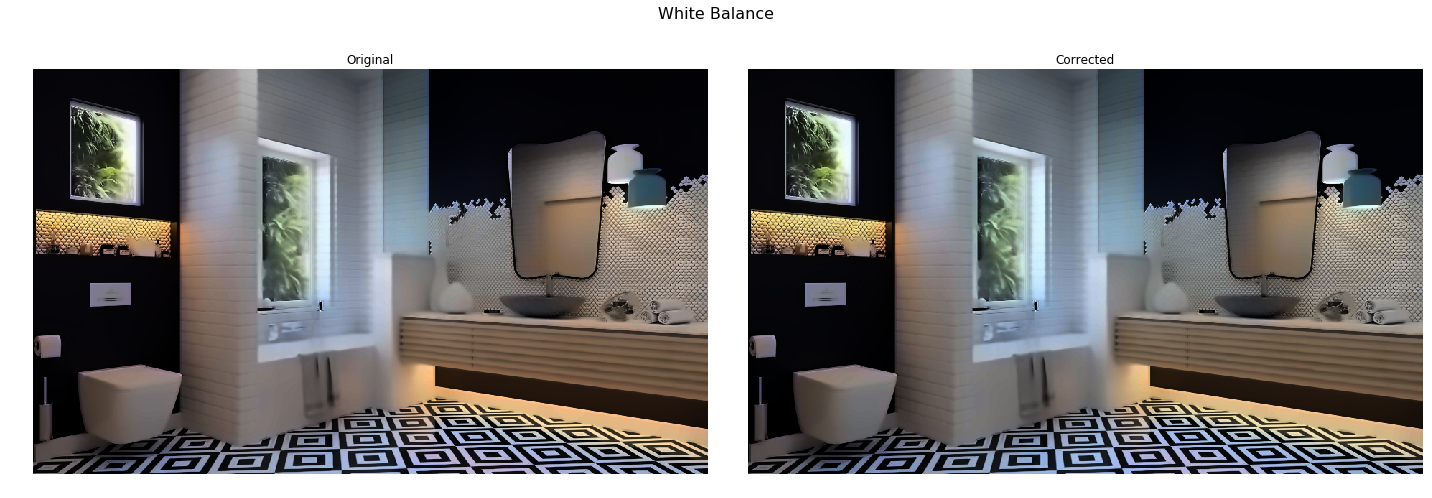

--- Stage: local_tone_mapping ---


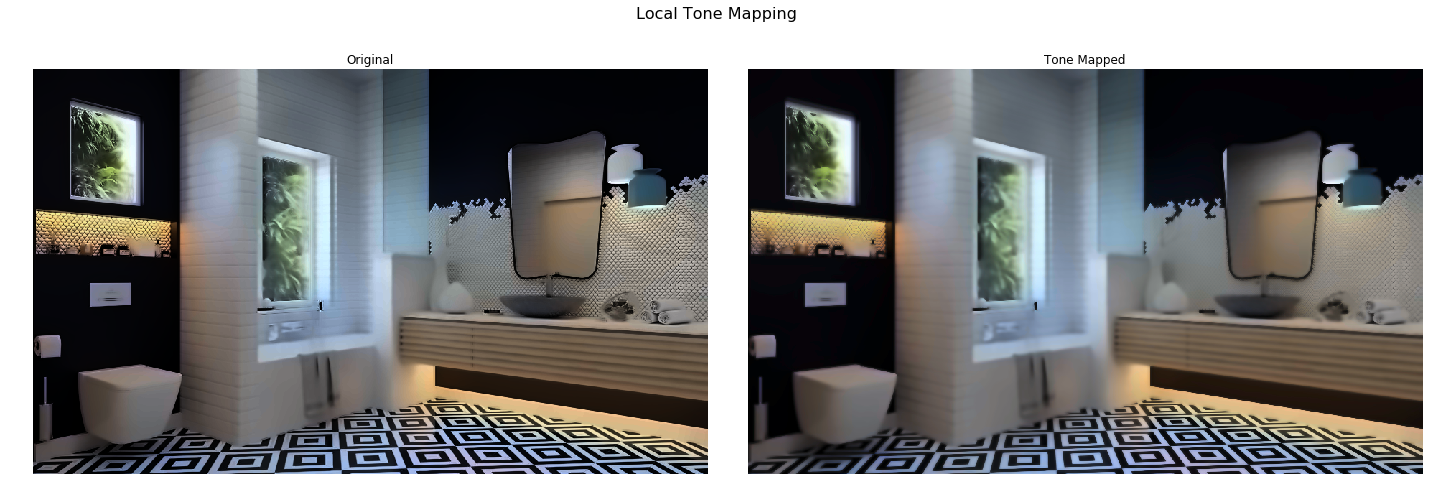

--- Stage: colour_enhancement ---


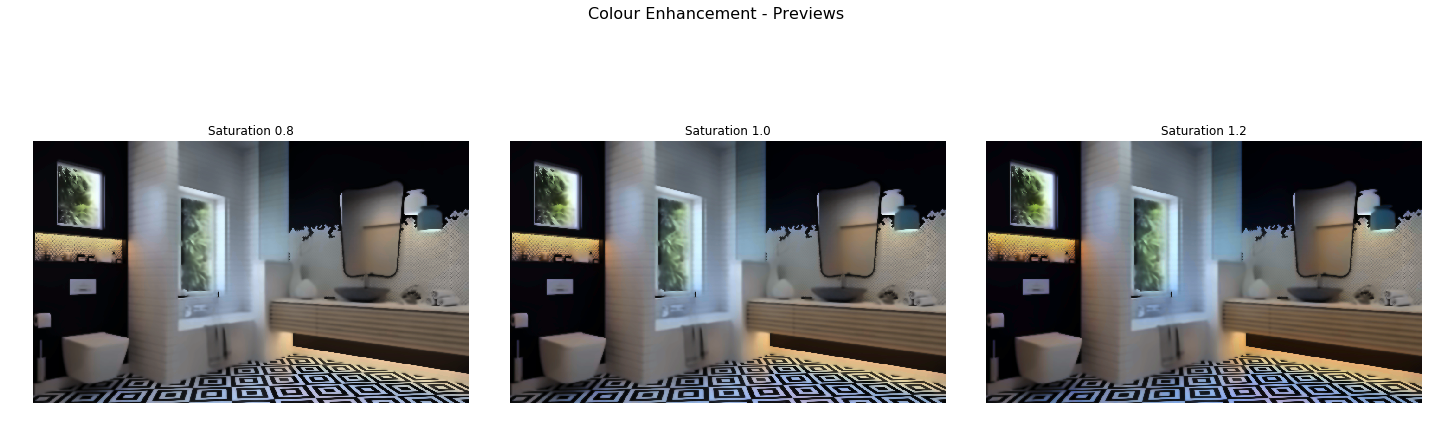

Adjust the trackbar, press any key when satisfied...
--- Stage: sharpening ---


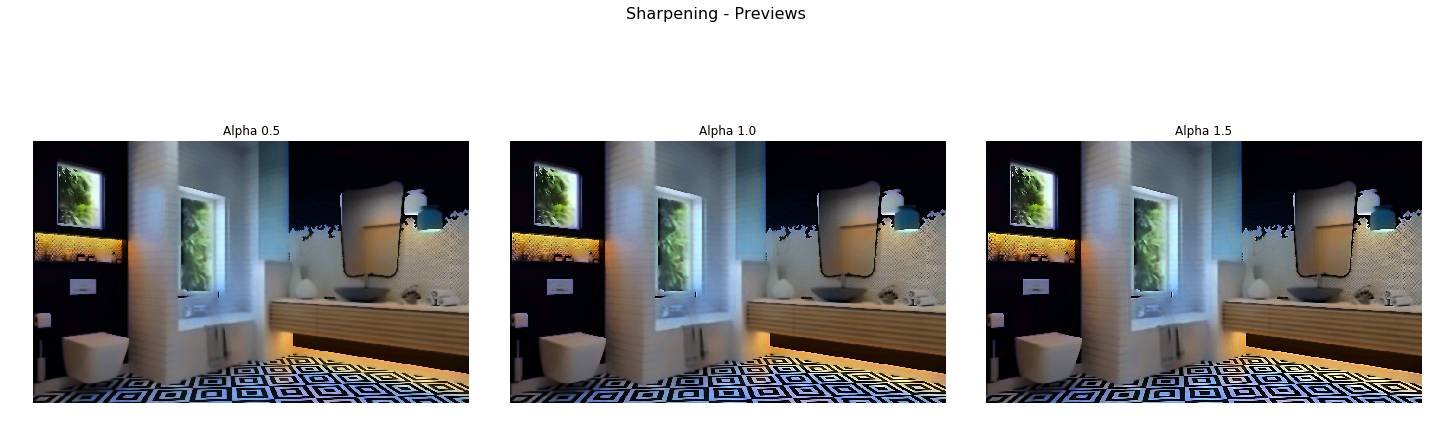

Adjust the trackbar, press any key when satisfied...


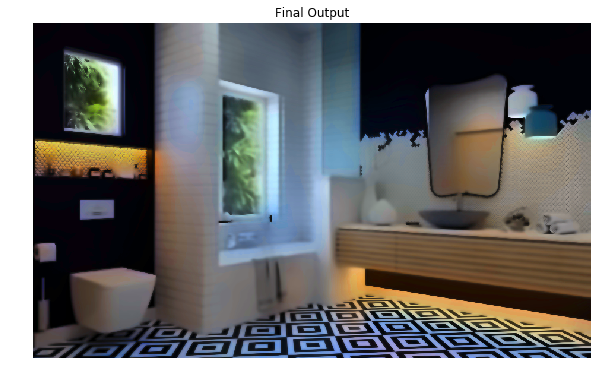

In [23]:
if __name__ == "__main__":
    img1 = cv2.imread(r"PATH/TO/IMAGE")
    img = smart_preprocess(img1)

    current_img = img
    for stage_name in pipeline_c_order:
        print(f"--- Stage: {stage_name} ---")
        current_img = pipeline_stages[stage_name](current_img)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(current_img, cv2.COLOR_BGR2RGB))
    plt.title("Final Output")
    plt.axis('off')
    plt.show()